<span style="font-size: 250%"> Partie 3 : Analyse les données </span>

# Importation les librairies

In [1]:
import pandas as pd # (version pandas 1.4.2)
import numpy as np  # (version numpy 1.22.4)
import seaborn as sns # (version seaborn 0.11.2)
import scipy.stats as st

import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import plotly.graph_objects as go
#import lux

from scipy.stats import shapiro
from scipy.spatial.distance import cdist

from fonction import detection_outliers_interquantile
from fonction import testerCle
from fonction import moving_average
from fonction import display_circles
from fonction import plot_dendrogram
from fonction import display_factorial_planes
from fonction import display_scree_plot

colors = ["#b2eca7","#ffcc97","#676283","#72bbff","#d2a0f2","#0abdc0"]

# Pour éviter d'avoir les messages warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing, cluster, metrics, decomposition

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage, fcluster 

from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

import folium
import json

# Importation des données nettoyées

In [3]:
df_final0 = pd.read_csv('df_final.csv') 

In [4]:
df_final0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Zone                                 145 non-null    object 
 1   Facilité de faire des affaires 2020  145 non-null    float64
 2   Population (2017)                    145 non-null    float64
 3   Evo 2015_2017 %                      145 non-null    float64
 4   Dispo intérieure poulet              145 non-null    float64
 5   Exportations poulet                  145 non-null    float64
 6   Importations poulet                  145 non-null    float64
 7   Production poulet                    145 non-null    float64
 8   Consommation poulet                  145 non-null    float64
 9   PIB (US$)                            145 non-null    float64
 10  Taux_import_poulet %                 145 non-null    float64
 11  Taux_export_poulet %            

In [5]:
df_final0.head()

,Zone,Facilité de faire des affaires 2020,Population (2017),Evo 2015_2017 %,Dispo intérieure poulet,Exportations poulet,Importations poulet,Production poulet,Consommation poulet,PIB (US$),Taux_import_poulet %,Taux_export_poulet %,Taux_conso_poulet %,Taux_dispo_intér_poulet %,Index de stabilité,Taux des droits de douane
0,Afghanistan,44.1,36296113.0,5.5,57.0,0.0,29.0,28.0,55.0,520.616409,0.64,0.00,0.42,0.38,-2.80,5.63
1,Afrique du Sud,67.0,57009756.0,2.9,2118.0,63.0,514.0,1667.0,2035.0,6121.876572,5.70,0.57,6.41,3.17,-0.28,4.40
2,Albanie,67.7,2884169.0,-0.2,47.0,0.0,38.0,13.0,47.0,4514.204908,4.30,0.00,1.29,0.96,0.38,1.10
3,Algérie,48.6,41389189.0,4.2,277.0,0.0,2.0,275.0,264.0,4109.696001,0.01,0.00,0.80,0.61,-0.92,10.16
4,Allemagne,79.7,82658409.0,1.1,1739.0,646.0,842.0,1514.0,1609.0,44651.829102,1.27,1.10,2.06,0.99,0.59,1.48


In [6]:
df_final = df_final0

Passer certaine variable en log pour éviter l'effet taille

In [7]:
df_final['Population (2017)'] =np.log2(df_final['Population (2017)'])
df_final['PIB (US$)'] =np.log2(df_final['PIB (US$)'])
#df_final['Dispo intérieure poulet'] =np.log2(df_final['Dispo intérieure poulet'])
#df_final['Production poulet'] =np.log2(df_final['Production poulet'])
#df_final['Consommation poulet'] =np.log2(df_final['Consommation poulet'])

In [8]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Zone                                 145 non-null    object 
 1   Facilité de faire des affaires 2020  145 non-null    float64
 2   Population (2017)                    145 non-null    float64
 3   Evo 2015_2017 %                      145 non-null    float64
 4   Dispo intérieure poulet              145 non-null    float64
 5   Exportations poulet                  145 non-null    float64
 6   Importations poulet                  145 non-null    float64
 7   Production poulet                    145 non-null    float64
 8   Consommation poulet                  145 non-null    float64
 9   PIB (US$)                            145 non-null    float64
 10  Taux_import_poulet %                 145 non-null    float64
 11  Taux_export_poulet %            

# Centrage et Reduction des variables
Afin de rendre les variables comparables entre elles pour notre clustering, nous allons les centrer/reduire.
Variable centrée réduite = de combien d'écart type la variable s'écarte de la moyenne = x-moyenne/écart type

In [9]:
#Créer la fonction vcr pour calculer une variable centrée réduite 
def vcr(x):
    A = x-x.mean()
    vcr = A/[np.std(x)]
    return vcr

Création DF avec variables centrées réduites

In [10]:
DF = pd.DataFrame(df_final, columns = ['Zone'])
list_var = ['Facilité de faire des affaires 2020',
            'Population (2017)', 
            'Evo 2015_2017 %', 
            'Dispo intérieure poulet',
            'Exportations poulet',
            'Importations poulet', 
            'Production poulet', 
            'Consommation poulet',
            'PIB (US$)',
            'Taux_import_poulet %', 
            'Taux_export_poulet %', 
            'Taux_conso_poulet %',
            'Taux_dispo_intér_poulet %',
            'Index de stabilité',
            'Taux des droits de douane']
for var in list_var:
    DF[var + "_vcr"] = vcr(df_final[var])
DF

,Zone,Facilité de faire des affaires 2020_vcr,Population (2017)_vcr,Evo 2015_2017 %_vcr,Dispo intérieure poulet_vcr,Exportations poulet_vcr,Importations poulet_vcr,Production poulet_vcr,Consommation poulet_vcr,PIB (US$)_vcr,Taux_import_poulet %_vcr,Taux_export_poulet %_vcr,Taux_conso_poulet %_vcr,Taux_dispo_intér_poulet %_vcr,Index de stabilité_vcr,Taux des droits de douane_vcr
0,Afghanistan,-1.556536,0.850416,1.215183,-0.486367,-0.320278,-0.326302,-0.519144,-0.477757,-1.737626,-0.502576,-0.553149,-1.007537,-0.750113,-2.917882,-0.004812
1,Afrique du Sud,0.245772,1.097323,0.117354,2.296753,0.019569,2.311002,1.749029,2.302161,0.050079,0.832374,0.293319,1.382848,0.865832,-0.192507,-0.271365
2,Albanie,0.300864,-0.534452,-1.191596,-0.499871,-0.320278,-0.277362,-0.539903,-0.488989,-0.170891,0.463020,-0.553149,-0.660352,-0.414182,0.521282,-0.986507
3,Algérie,-1.202371,0.922222,0.666269,-0.189285,-0.320278,-0.473121,-0.177327,-0.184321,-0.238987,-0.668785,-0.553149,-0.855893,-0.616899,-0.884666,0.976882
4,Allemagne,1.245305,1.300472,-0.642681,1.784962,3.164503,4.094581,1.537296,1.704058,1.491369,-0.336367,1.080386,-0.353074,-0.396806,0.748397,-0.904158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,Venezuela (République bolivarienne du),-2.650514,0.735234,-2.078304,0.281995,-0.320278,-0.348053,0.272433,0.281807,0.282336,-0.528958,-0.553149,0.341295,0.726826,-1.241560,1.822050
141,Viet Nam,0.466141,1.374268,-0.220439,1.065212,-0.314884,1.098386,0.712505,1.082086,-0.639635,-0.370664,-0.553149,-0.484765,-0.385222,0.423947,-0.934497
142,Yémen,-2.524588,0.705271,1.004062,-0.231147,-0.320278,-0.059853,-0.325402,-0.222229,-1.477597,-0.336367,-0.553149,-0.049787,0.628363,-3.069292,-0.134838
143,Zambie,0.237901,0.430907,1.468529,-0.482316,-0.314884,-0.418744,-0.490083,-0.473545,-0.953385,-0.069904,-0.374945,-0.788052,-0.686402,0.272538,-0.180347


# Classification ascendante hiérarchique (CAH)

CAH est une méthode de regroupement. Il permet de créer un arbre qui regroupe les différents individus de façon plus ou moins forte en fonction de la profondeur choisie. </br>
Principe:  Elle est une méthode de classification itérative. On considère tout d'abord que chaque point est un cluster. Il y a donc autant de clusters que de points. Ensuite, on cherche les deux clusters les plus proches, et on les agglomère en un seul cluster. On répète cette étape jusqu'à ce que tous les points soient regroupés en un seul grand cluster.  

Méthode des liens et méthode de Ward </br>
Que ce soit avec l'approche ascendante ou descendante, on a besoin de mesurer la distance entre 2 clusters.</br>
comme un cluster est composé de plusieurs points, il y a différentes manières de considérer une distance entre 2 clusters. On les appelle les méthodes de lien (linkage methods), car ce sont elles qui permettent de lier les clusters lorsque l'on construit petit à petit l'arborescence.</br>

On a :</br>

Le lien simple (simple linkage) : on considère que la distance entre 2 clusters est la distance entre leurs 2 points les plus proches. Cela est équivalent à dire "deux clusters sont proches si au moins deux de leurs points sont proches".</br>
Le lien complet (complete linkage) : on considère que la distance entre 2 clusters est la distance entre leurs 2 points les plus éloignés. Cela équivaut donc à dire "deux clusters sont proches si tous leurs points sont proches".</br>
Le lien moyen : on considère que la distance entre 2 clusters est la moyenne de toutes les distances entre les points d'un cluster et les points de l'autre cluster. Pour la calculer, on énumère toutes les paires de points possibles d'un cluster à l'autre, puis on calcule la distance de chaque paire, puis on calcule la moyenne.</br>
Le lien centroïdal : on considère que la distance entre 2 clusters est la distance entre les centroïdes de ceux-ci.

Elles ne garantissent pas que les clusters soient resserrés sur eux-mêmes (c'est la notion d'inertie intraclasse). Pour résoudre cela, il existe la méthode de Ward qui, à chaque itération, c'est-à-dire à chaque fois que 2 clusters sont regroupés en 1, cherche à minimiser l'augmentation d'inertie intraclasse due au regroupement des 2 clusters.

## Dendrogramme

### Normalisons nos données

In [11]:
# préparation des données pour le clustering
# Indexation par la colonne Zone
#X = df_final.values
X = df_final.set_index('Zone')

In [12]:
# Centrage et Réduction # 
#scaler = preprocessing.RobustScaler().fit(X)
scaler = preprocessing.StandardScaler().fit(X)
#scaler = StandardScaler().fit(X)
X_scaled = scaler.fit_transform(X)

In [13]:
# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')
#Z = linkage(X, 'ward')
names = X.index

In [14]:
data_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
data_scaled.head()

,Facilité de faire des affaires 2020,Population (2017),Evo 2015_2017 %,Dispo intérieure poulet,Exportations poulet,Importations poulet,Production poulet,Consommation poulet,PIB (US$),Taux_import_poulet %,Taux_export_poulet %,Taux_conso_poulet %,Taux_dispo_intér_poulet %,Index de stabilité,Taux des droits de douane
Zone,,,,,,,,,,,,,,,
Afghanistan,-1.556536,0.850416,1.215183,-0.486367,-0.320278,-0.326302,-0.519144,-0.477757,-1.737626,-0.502576,-0.553149,-1.007537,-0.750113,-2.917882,-0.004812
Afrique du Sud,0.245772,1.097323,0.117354,2.296753,0.019569,2.311002,1.749029,2.302161,0.050079,0.832374,0.293319,1.382848,0.865832,-0.192507,-0.271365
Albanie,0.300864,-0.534452,-1.191596,-0.499871,-0.320278,-0.277362,-0.539903,-0.488989,-0.170891,0.463020,-0.553149,-0.660352,-0.414182,0.521282,-0.986507
Algérie,-1.202371,0.922222,0.666269,-0.189285,-0.320278,-0.473121,-0.177327,-0.184321,-0.238987,-0.668785,-0.553149,-0.855893,-0.616899,-0.884666,0.976882
Allemagne,1.245305,1.300472,-0.642681,1.784962,3.164503,4.094581,1.537296,1.704058,1.491369,-0.336367,1.080386,-0.353074,-0.396806,0.748397,-0.904158


In [15]:
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 145 entries, Afghanistan to Zimbabwe
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Facilité de faire des affaires 2020  145 non-null    float64
 1   Population (2017)                    145 non-null    float64
 2   Evo 2015_2017 %                      145 non-null    float64
 3   Dispo intérieure poulet              145 non-null    float64
 4   Exportations poulet                  145 non-null    float64
 5   Importations poulet                  145 non-null    float64
 6   Production poulet                    145 non-null    float64
 7   Consommation poulet                  145 non-null    float64
 8   PIB (US$)                            145 non-null    float64
 9   Taux_import_poulet %                 145 non-null    float64
 10  Taux_export_poulet %                 145 non-null    float64
 11  Taux_conso_poulet %   

### Dendrogramme

In [16]:
def plot_dendrogram(Z, names, figsize=(15,30)):
    '''Plot a dendrogram to illustrate hierarchical clustering'''

    plt.figure(figsize=figsize)
    plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
    plt.ylabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "top",
        leaf_font_size=14,
    )

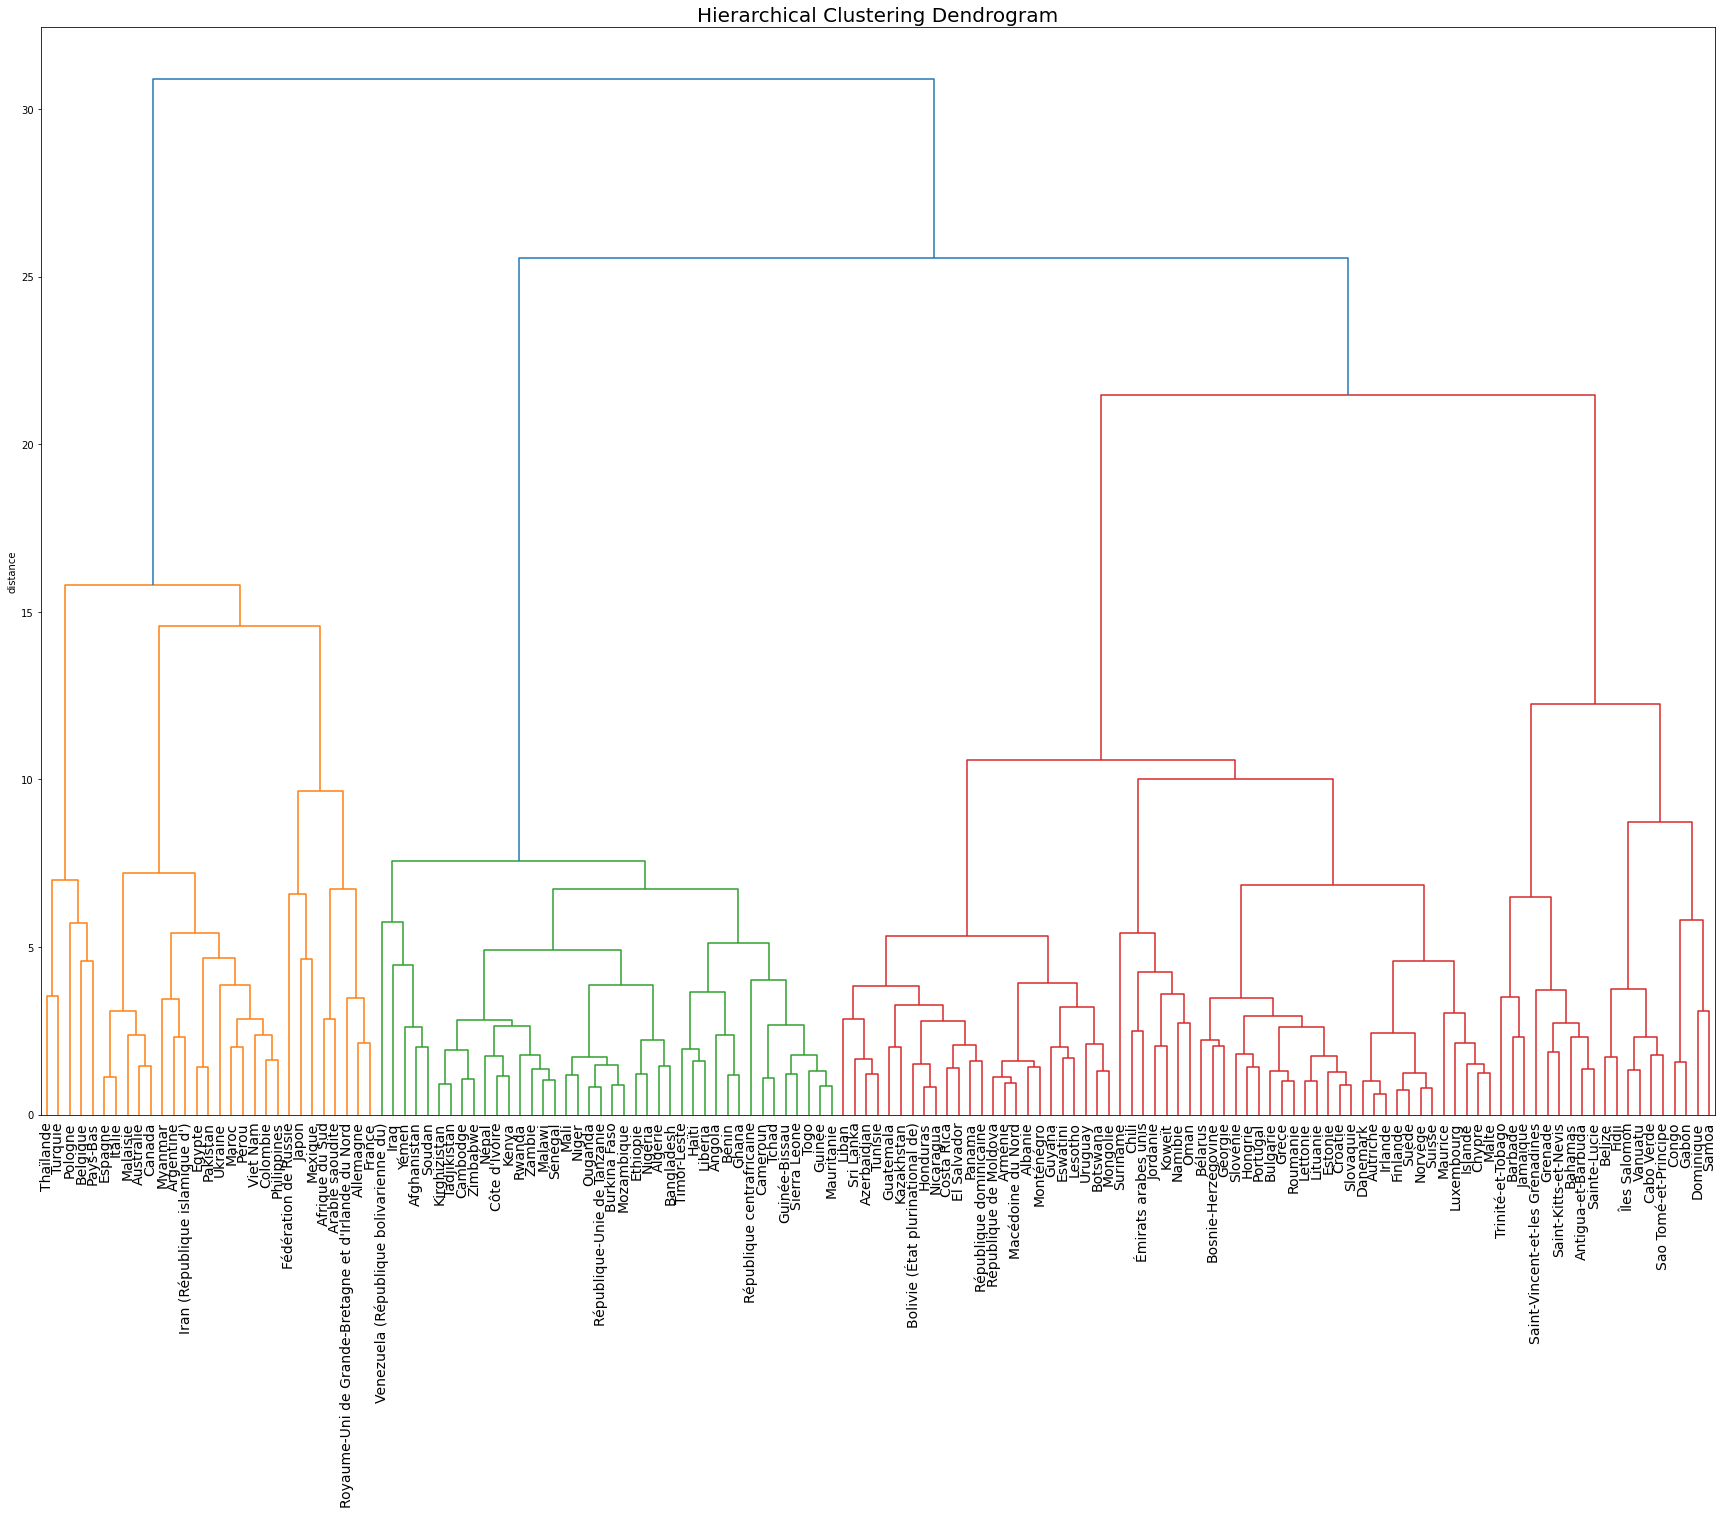

In [17]:
# Affichage du dendrogramme
plot_dendrogram(Z, names, figsize=(30,20))

La clé ici, c'est la distance entre clusters, sur l'axe des y. Plus elle est grande, plus il y a de clusters.

## Coupons du dendrogramme

In [18]:
#clusters = fcluster(Z, 19, criterion = 'distance')
#dfclust = pd.DataFrame({'clusters cah': clusters, 'pays': names})
#dfclust

In [19]:
# Créer un modèle de clustering hiérarchique
hiercluster = AgglomerativeClustering(affinity='euclidean', linkage='ward', compute_full_tree=True) 

In [20]:
# Découpe du dendrogramme en clusters
hiercluster.set_params(n_clusters=4)
clusters = hiercluster.fit_predict(X_scaled) 

In [21]:
# Ajouter le numéro de cluster aux données originales
X_scaled_clustered = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered["Clusters"] = clusters
X_scaled_clustered.head()

,Facilité de faire des affaires 2020,Population (2017),Evo 2015_2017 %,Dispo intérieure poulet,Exportations poulet,Importations poulet,Production poulet,Consommation poulet,PIB (US$),Taux_import_poulet %,Taux_export_poulet %,Taux_conso_poulet %,Taux_dispo_intér_poulet %,Index de stabilité,Taux des droits de douane,Clusters
Zone,,,,,,,,,,,,,,,,
Afghanistan,-1.556536,0.850416,1.215183,-0.486367,-0.320278,-0.326302,-0.519144,-0.477757,-1.737626,-0.502576,-0.553149,-1.007537,-0.750113,-2.917882,-0.004812,2
Afrique du Sud,0.245772,1.097323,0.117354,2.296753,0.019569,2.311002,1.749029,2.302161,0.050079,0.832374,0.293319,1.382848,0.865832,-0.192507,-0.271365,0
Albanie,0.300864,-0.534452,-1.191596,-0.499871,-0.320278,-0.277362,-0.539903,-0.488989,-0.170891,0.463020,-0.553149,-0.660352,-0.414182,0.521282,-0.986507,3
Algérie,-1.202371,0.922222,0.666269,-0.189285,-0.320278,-0.473121,-0.177327,-0.184321,-0.238987,-0.668785,-0.553149,-0.855893,-0.616899,-0.884666,0.976882,2
Allemagne,1.245305,1.300472,-0.642681,1.784962,3.164503,4.094581,1.537296,1.704058,1.491369,-0.336367,1.080386,-0.353074,-0.396806,0.748397,-0.904158,0


In [22]:
# Trouver les tailles des clusters
X_scaled_clustered["Clusters"].value_counts()

3    57
2    40
0    29
1    19
Name: Clusters, dtype: int64

In [23]:
# Montrer un dendrogramme, juste pour le cluster 
#sample = X_scaled_clustered[X_scaled_clustered.Clusters==2]
#Z = linkage(sample, 'ward') 
#names = sample.index 
#plot_dendrogram(Z, names, figsize=(5,9))

## Affichier les pays de chaque groupe

In [24]:
groupe0 = X_scaled_clustered[X_scaled_clustered.Clusters==0]

In [25]:
pays_0 = groupe0.index
pays_0

Index(['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Argentine',
       'Australie', 'Belgique', 'Canada', 'Colombie', 'Égypte', 'Espagne',
       'France', 'Iran (République islamique d')', 'Italie', 'Japon',
       'Malaisie', 'Maroc', 'Mexique', 'Myanmar', 'Pakistan', 'Pays-Bas',
       'Pérou', 'Philippines', 'Pologne',
       'Royaume-Uni de Grande-Bretagne et d'Irlande du Nord',
       'Fédération de Russie', 'Thaïlande', 'Turquie', 'Ukraine', 'Viet Nam'],
      dtype='object', name='Zone')

In [26]:
groupe1 = X_scaled_clustered[X_scaled_clustered.Clusters==1]
pays_1 = groupe1.index
pays_1

Index(['Antigua-et-Barbuda', 'Bahamas', 'Barbade', 'Belize', 'Cabo Verde',
       'Congo', 'Dominique', 'Fidji', 'Gabon', 'Grenade', 'Îles Salomon',
       'Jamaïque', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines',
       'Sainte-Lucie', 'Samoa', 'Sao Tomé-et-Principe', 'Trinité-et-Tobago',
       'Vanuatu'],
      dtype='object', name='Zone')

In [27]:
groupe2 = X_scaled_clustered[X_scaled_clustered.Clusters==2]
pays_2 = groupe2.index
pays_2

Index(['Afghanistan', 'Algérie', 'Angola', 'Bangladesh', 'Bénin',
       'Burkina Faso', 'Cambodge', 'Cameroun', 'Côte d'Ivoire', 'Éthiopie',
       'Ghana', 'Guinée', 'Guinée-Bissau', 'Haïti', 'Iraq', 'Kenya',
       'Kirghizistan', 'Libéria', 'Malawi', 'Mali', 'Mauritanie', 'Mozambique',
       'Népal', 'Niger', 'Nigéria', 'Ouganda', 'République centrafricaine',
       'Rwanda', 'Sénégal', 'Sierra Leone', 'Soudan', 'Tadjikistan',
       'République-Unie de Tanzanie', 'Tchad', 'Timor-Leste', 'Togo',
       'Venezuela (République bolivarienne du)', 'Yémen', 'Zambie',
       'Zimbabwe'],
      dtype='object', name='Zone')

In [28]:
groupe3 = X_scaled_clustered[X_scaled_clustered.Clusters==3]
pays_3 = groupe3.index
pays_3

Index(['Albanie', 'Arménie', 'Autriche', 'Azerbaïdjan', 'Bélarus',
       'Bolivie (État plurinational de)', 'Bosnie-Herzégovine', 'Botswana',
       'Bulgarie', 'Chili', 'Chypre', 'Costa Rica', 'Croatie', 'Danemark',
       'El Salvador', 'Émirats arabes unis', 'Estonie', 'Eswatini', 'Finlande',
       'Géorgie', 'Grèce', 'Guatemala', 'Guyana', 'Honduras', 'Hongrie',
       'Irlande', 'Islande', 'Jordanie', 'Kazakhstan', 'Koweït', 'Lesotho',
       'Lettonie', 'Liban', 'Lituanie', 'Luxembourg', 'Macédoine du Nord',
       'Malte', 'Maurice', 'République de Moldova', 'Mongolie', 'Monténégro',
       'Namibie', 'Nicaragua', 'Norvège', 'Oman', 'Panama', 'Portugal',
       'République dominicaine', 'Roumanie', 'Slovaquie', 'Slovénie',
       'Sri Lanka', 'Suède', 'Suisse', 'Suriname', 'Tunisie', 'Uruguay'],
      dtype='object', name='Zone')

In [29]:
Dcluster0 = X_scaled_clustered.loc[X_scaled_clustered['Clusters']== 0]
Dcluster1 = X_scaled_clustered.loc[X_scaled_clustered['Clusters']== 1]
Dcluster2 = X_scaled_clustered.loc[X_scaled_clustered['Clusters']== 2]
Dcluster3 = X_scaled_clustered.loc[X_scaled_clustered['Clusters']== 3]

In [30]:
#Dcluster0

 ## Heatmap - dendrogramme

In [31]:
X_clustered_moy = X_scaled_clustered.groupby('Clusters').mean()

In [32]:
X_scaled_clustered['Clusters'].unique()

array([2, 0, 3, 1])

In [33]:
X_clustered_moy

,Facilité de faire des affaires 2020,Population (2017),Evo 2015_2017 %,Dispo intérieure poulet,Exportations poulet,Importations poulet,Production poulet,Consommation poulet,PIB (US$),Taux_import_poulet %,Taux_export_poulet %,Taux_conso_poulet %,Taux_dispo_intér_poulet %,Index de stabilité,Taux des droits de douane
Clusters,,,,,,,,,,,,,,,
0,0.631418,1.086562,-0.331096,1.646013,1.022369,1.041384,1.726887,1.611539,0.473376,-0.375213,0.568818,0.197082,-0.033513,-0.177217,-0.543373
1,-0.560317,-1.665310,-0.098212,-0.522188,-0.319995,-0.385258,-0.538300,-0.516330,0.222848,1.692024,-0.510943,1.396290,1.515441,0.743843,1.337647
2,-0.950717,0.479431,0.955505,-0.414190,-0.320144,-0.275459,-0.456801,-0.405591,-1.147249,-0.234662,-0.548694,-0.792941,-0.575342,-0.871688,0.709842
3,0.532694,-0.334152,-0.469340,-0.372723,-0.188825,-0.208103,-0.378596,-0.363171,0.489964,-0.208435,0.265964,-0.009250,-0.084348,0.453926,-0.667564


In [34]:
#X_centroides_cah = pd.pivot_table(X_scaled_clustered, index ='Clusters', values= X_scaled_clustered.columns , aggfunc= 'mean')


<AxesSubplot:ylabel='Clusters'>

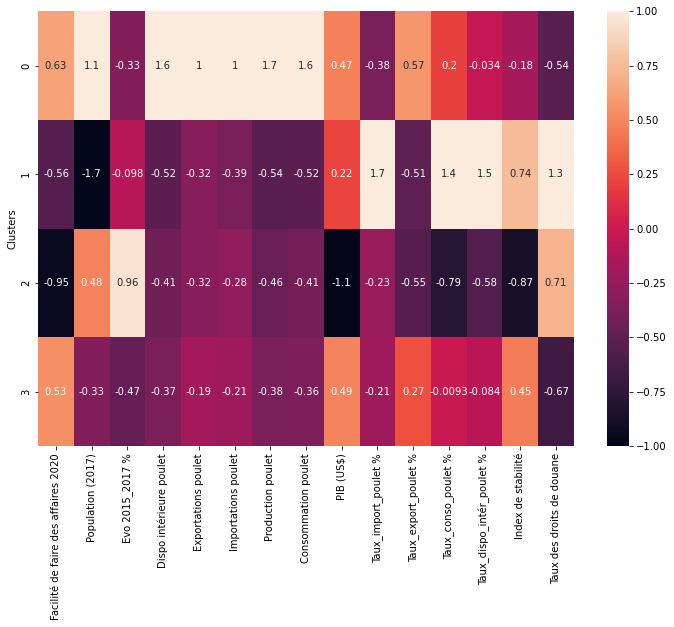

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(X_clustered_moy,annot=True, vmin=-1, vmax=1)


In [36]:
#fig, ax = plt.subplots(figsize=(12, 8))
#sns.heatmap(X_centroides_cah,annot=True, vmin=-1, vmax=1)

cluster 0 : avec ses Facilité de faire des affaires 2020, populations(2017), disponibilité intérieure, exportation, production, consommation de poulet, importation poulet , PIB, très élevés, est le groupement de pays le plus intéressant pour exporter nos poulets. Nous le vérifirons avec le ACP plus tard.

# K-means

## Choisir le nombre de clusters avec la méthode du coude

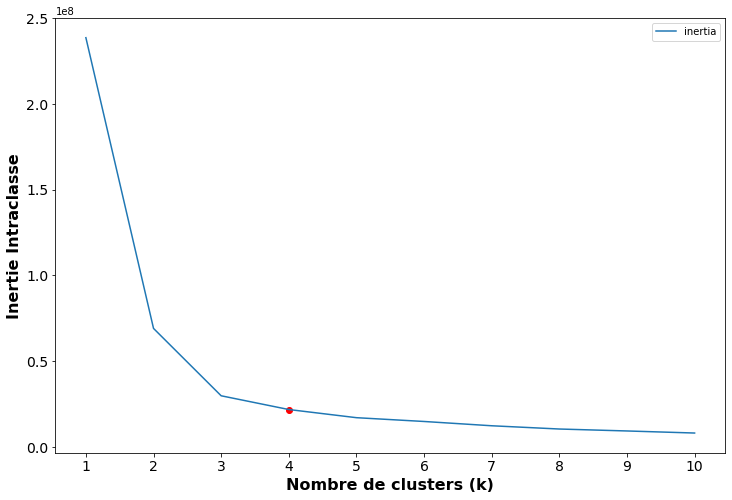

In [37]:
# Une liste vide pour enregistrer les inerties : 
a=[]

# Notre liste de nombres de clusters : 
k_list = range(1, 11)

# Pour chaque nombre de clusters :
for k in k_list:
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k, max_iter = 200) 
    # On entraine
    kmeans.fit(X)
    # On enregistre l'inertie obtenue :
    a.append(kmeans.inertia_)
 
a = pd.DataFrame({"k": k_list, "inertia": a})
a.plot.line(x = "k", y = "inertia", figsize = (12,8))
plt.scatter(4, a.query('k == 4')["inertia"], c = "red")
plt.ylabel('Inertie Intraclasse', weight='bold',size=16)
plt.xlabel('Nombre de clusters (k)', weight='bold',size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xticks(np.arange(1, 11, 1))
plt.show()

Je choisis le K-means avec 4 clusters.

In [38]:
#DFzone = DF.set_index('Zone')
#x = DFzone.values 
#y = DFzone.index

#silhouettes = []
#for num_clusters in range(3, 12):
#    cls = cluster.KMeans(n_clusters = num_clusters,
#                         n_init = 100, init = 'random')

#    cls.fit(x)
#    silh = metrics.silhouette_score(x, cls.labels_)
#    silhouettes.append(silh)
    
#plt.plot(range(3, 12),silhouettes, marker = 'o')

,2,3,4,5,6,7,8
coefficient de silhouette,0.314738,0.24376,0.267664,0.27772,0.285703,0.211671,0.20022


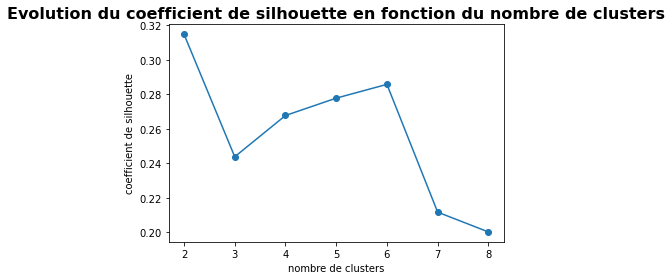

In [39]:
silhouette = []
k_range = range(2, 9)
for num_cls in range(2, 9):
#    modelkm = KMeans(n_clusters = num_cls)
#    modelkm.fit_predict(X_scaled)
#    cluster_labels = modelkm.fit_predict(X_scaled)

    cls = cluster.KMeans(n_clusters = num_cls,
                         n_init = 100, init = 'random')

    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouette.append(silh)
    
plt.plot(range(2, 9), silhouette, marker = 'o')
plt.xlabel('nombre de clusters')
plt.ylabel('coefficient de silhouette')
plt.title('Evolution du coefficient de silhouette en fonction du nombre de clusters', fontsize=16, fontweight='bold')
plt.show
silhouette = pd.DataFrame(silhouette, index = np.arange(2, 9), columns=['coefficient de silhouette']).T
silhouette

## Clustering par K-means

In [40]:
# Clustering par K-means
kmeans = KMeans(init='random', n_clusters=4, n_init=20)

In [41]:
kmeans.fit(X_scaled)

KMeans(init='random', n_clusters=4, n_init=20)

In [42]:
# Récupération des clusters attribués à chaque individu
clusters_k = kmeans.labels_

In [43]:
# Ajouter le nombre de clusters aux données originelles
X_scaled_clustered_km = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_clustered_km['cluster_k'] = clusters_k

#X_scaled_clustered=X_scaled_clustered.reset_index()

In [44]:
X_scaled_clustered_km.head()

,Facilité de faire des affaires 2020,Population (2017),Evo 2015_2017 %,Dispo intérieure poulet,Exportations poulet,Importations poulet,Production poulet,Consommation poulet,PIB (US$),Taux_import_poulet %,Taux_export_poulet %,Taux_conso_poulet %,Taux_dispo_intér_poulet %,Index de stabilité,Taux des droits de douane,cluster_k
Zone,,,,,,,,,,,,,,,,
Afghanistan,-1.556536,0.850416,1.215183,-0.486367,-0.320278,-0.326302,-0.519144,-0.477757,-1.737626,-0.502576,-0.553149,-1.007537,-0.750113,-2.917882,-0.004812,1
Afrique du Sud,0.245772,1.097323,0.117354,2.296753,0.019569,2.311002,1.749029,2.302161,0.050079,0.832374,0.293319,1.382848,0.865832,-0.192507,-0.271365,2
Albanie,0.300864,-0.534452,-1.191596,-0.499871,-0.320278,-0.277362,-0.539903,-0.488989,-0.170891,0.463020,-0.553149,-0.660352,-0.414182,0.521282,-0.986507,0
Algérie,-1.202371,0.922222,0.666269,-0.189285,-0.320278,-0.473121,-0.177327,-0.184321,-0.238987,-0.668785,-0.553149,-0.855893,-0.616899,-0.884666,0.976882,1
Allemagne,1.245305,1.300472,-0.642681,1.784962,3.164503,4.094581,1.537296,1.704058,1.491369,-0.336367,1.080386,-0.353074,-0.396806,0.748397,-0.904158,2


In [45]:
# Trouver les tailles des clusters
X_scaled_clustered_km["cluster_k"].value_counts()

1    55
0    54
2    23
3    13
Name: cluster_k, dtype: int64

In [46]:
#sns.scatterplot(X_scaled_clustered_km[0],X_scaled_clustered_km[1],hue=label)

In [47]:
#group00 = X_scaled_clustered_km["cluster_k"]
#group00.head(23)

## Centre de classe

In [48]:
# On instancie notre Kmeans avec 3 clusters : 
#kmeans = KMeans(n_clusters=4)

# On l'entraine : 
#kmeans.fit(X)

# On peut stocker nos clusters dans une variable labels : 
#labels = kmeans.labels_

# On peut stocker nos centroids dans une variable : 
#centroids = kmeans.cluster_centers_

In [49]:
# On commence donc par scaler nos données :
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

In [50]:
# Ensuite on fait notre ACP, ici avec 4 composantes :
#pca = PCA(n_components=4)
#pca.fit(X_scaled)

In [51]:
# Enfin, on projette nos points dans le "nouvel espace" :
#X_proj = pca.transform(X_scaled)
#X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2", "PC3", "PC4"])
#X_proj[:10]

In [52]:
# On utilise bien le scaler déjà entrainé : 

#centroids_proj = scaler.transform(centroids)

In [53]:
# On définit notre figure et son axe : 
#fig, ax = plt.subplots(1,1, figsize=(8,7))

# On affiche nos individus, avec une transparence de 50% (alpha=0.5) : 
#ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1", alpha =0.5)

# On affiche nos centroides, avec une couleur noire (c="black") et une frome de carré (marker="c") : 
#ax.scatter(centroids_proj.iloc[:, 0], centroids_proj.iloc[:, 1],  marker="s", c="black" )

# On spécifie les axes x et y :
#ax.set_xlabel("F1")
#ax.set_ylabel("F2")
#plt.show()

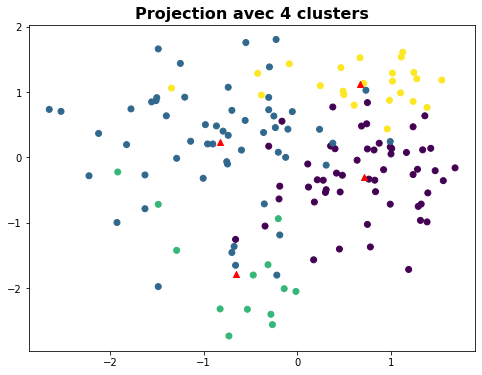

In [54]:
km4 = cluster.KMeans(n_clusters=4)
modelkm4 = km4.fit_predict(X_scaled)
centroid4 = km4.cluster_centers_

fig = plt.figure(figsize=(8,6))
plt.scatter(X_scaled[:,0],X_scaled[:,1], c=modelkm4)
plt.scatter(centroid4[:,0], centroid4[:,1], marker='^', c='red')
plt.title('Projection avec 4 clusters', fontsize=16, fontweight='bold');

## Affichier les pays de chaque groupe k-means

In [55]:
groupe0_km = X_scaled_clustered_km[X_scaled_clustered_km.cluster_k==0]
pays_0_km = groupe0_km.index
pays_0_km

Index(['Albanie', 'Arménie', 'Australie', 'Autriche', 'Azerbaïdjan', 'Bélarus',
       'Belgique', 'Bosnie-Herzégovine', 'Botswana', 'Bulgarie', 'Chili',
       'Chypre', 'Costa Rica', 'Croatie', 'Danemark', 'El Salvador',
       'Émirats arabes unis', 'Estonie', 'Eswatini', 'Finlande', 'Géorgie',
       'Grèce', 'Guyana', 'Hongrie', 'Irlande', 'Islande', 'Jamaïque',
       'Jordanie', 'Kazakhstan', 'Koweït', 'Lettonie', 'Lituanie',
       'Luxembourg', 'Macédoine du Nord', 'Malte', 'Maroc', 'Maurice',
       'République de Moldova', 'Mongolie', 'Monténégro', 'Namibie', 'Norvège',
       'Oman', 'Panama', 'Pérou', 'Portugal', 'République dominicaine',
       'Roumanie', 'Slovaquie', 'Slovénie', 'Sri Lanka', 'Suède', 'Suisse',
       'Uruguay'],
      dtype='object', name='Zone')

In [56]:
groupe0_km

,Facilité de faire des affaires 2020,Population (2017),Evo 2015_2017 %,Dispo intérieure poulet,Exportations poulet,Importations poulet,Production poulet,Consommation poulet,PIB (US$),Taux_import_poulet %,Taux_export_poulet %,Taux_conso_poulet %,Taux_dispo_intér_poulet %,Index de stabilité,Taux des droits de douane,cluster_k
Zone,,,,,,,,,,,,,,,,
Albanie,0.300864,-0.534452,-1.191596,-0.499871,-0.320278,-0.277362,-0.539903,-0.488989,-0.170891,0.463020,-0.553149,-0.660352,-0.414182,0.521282,-0.986507,0
Arménie,0.836047,-0.523077,-0.811578,-0.499871,-0.320278,-0.293675,-0.542670,-0.488989,-0.274279,0.420809,-0.553149,-0.540634,-0.350471,-0.560216,-0.550921,0
Australie,1.363360,0.637372,0.032906,1.017949,-0.093714,-0.396993,1.198246,1.089106,1.676426,-0.605467,-0.434346,0.919936,-0.101418,1.072846,-1.071024,0
Autriche,1.166602,0.076796,-0.431560,-0.329724,0.100485,0.114155,-0.353079,-0.330337,1.533299,-0.365387,0.931883,-0.396971,-0.448933,1.245886,-0.904158,0
Azerbaïdjan,1.009195,0.136941,-0.135991,-0.389141,-0.320278,-0.337177,-0.413970,-0.373861,-0.231756,-0.404961,-0.553149,-0.516690,-0.373639,-0.700811,0.060200,0
Bélarus,0.820307,0.114544,-1.064923,-0.205490,0.499670,-0.369804,0.082842,-0.184321,0.009764,-0.528958,2.461466,-0.029833,-0.443142,0.056238,-0.843479,0
Belgique,0.875399,0.218064,-0.600457,-0.358082,3.218447,1.353960,0.082842,-0.352801,1.481129,-0.441896,2.446616,-0.680305,-0.697986,0.575357,-0.904158,0
Bosnie-Herzégovine,0.119846,-0.452328,-2.078304,-0.489068,-0.277123,-0.429619,-0.473477,-0.476353,-0.041637,-0.555341,1.199189,-0.500727,-0.379430,-0.268212,-0.605098,0
Botswana,0.182809,-0.681265,0.581820,-0.553886,-0.320278,-0.467683,-0.550974,-0.545149,0.234429,-0.587000,-0.553149,-0.935706,-0.686402,1.213441,-1.051520,0


In [57]:
groupe1_km = X_scaled_clustered_km[X_scaled_clustered_km.cluster_k==1]
pays_1_km = groupe1_km.index
pays_1_km

Index(['Afghanistan', 'Algérie', 'Angola', 'Bangladesh', 'Belize', 'Bénin',
       'Bolivie (État plurinational de)', 'Burkina Faso', 'Cambodge',
       'Cameroun', 'Cabo Verde', 'Côte d'Ivoire', 'Égypte', 'Éthiopie',
       'Fidji', 'Ghana', 'Guatemala', 'Guinée', 'Guinée-Bissau', 'Haïti',
       'Honduras', 'Îles Salomon', 'Iraq', 'Kenya', 'Kirghizistan', 'Lesotho',
       'Liban', 'Libéria', 'Malawi', 'Mali', 'Mauritanie', 'Mozambique',
       'Népal', 'Nicaragua', 'Niger', 'Nigéria', 'Ouganda', 'Pakistan',
       'République centrafricaine', 'Rwanda', 'Sao Tomé-et-Principe',
       'Sénégal', 'Sierra Leone', 'Soudan', 'Tadjikistan',
       'République-Unie de Tanzanie', 'Tchad', 'Timor-Leste', 'Togo',
       'Tunisie', 'Vanuatu', 'Venezuela (République bolivarienne du)', 'Yémen',
       'Zambie', 'Zimbabwe'],
      dtype='object', name='Zone')

In [58]:
groupe2_km = X_scaled_clustered_km[X_scaled_clustered_km.cluster_k==2]
pays_2_km = groupe2_km.index
pays_2_km

Index(['Afrique du Sud', 'Allemagne', 'Arabie saoudite', 'Argentine', 'Canada',
       'Colombie', 'Espagne', 'France', 'Iran (République islamique d')',
       'Italie', 'Japon', 'Malaisie', 'Mexique', 'Myanmar', 'Pays-Bas',
       'Philippines', 'Pologne',
       'Royaume-Uni de Grande-Bretagne et d'Irlande du Nord',
       'Fédération de Russie', 'Thaïlande', 'Turquie', 'Ukraine', 'Viet Nam'],
      dtype='object', name='Zone')

In [59]:
groupe3_km = X_scaled_clustered_km[X_scaled_clustered_km.cluster_k==3]
pays_3_km = groupe3_km.index
pays_3_km

Index(['Antigua-et-Barbuda', 'Bahamas', 'Barbade', 'Congo', 'Dominique',
       'Gabon', 'Grenade', 'Saint-Kitts-et-Nevis',
       'Saint-Vincent-et-les Grenadines', 'Sainte-Lucie', 'Samoa', 'Suriname',
       'Trinité-et-Tobago'],
      dtype='object', name='Zone')

In [60]:
groupe4_km = X_scaled_clustered_km[X_scaled_clustered_km.cluster_k==4]
pays_4_km = groupe4_km.index
pays_4_km

Index([], dtype='object', name='Zone')

In [61]:
groupe5_km = X_scaled_clustered_km[X_scaled_clustered_km.cluster_k==5]
pays_5_km = groupe5_km.index
pays_5_km

Index([], dtype='object', name='Zone')

## Heatmap - K-means

In [62]:
X_clustered_moy = X_scaled_clustered_km.groupby('cluster_k').mean()

<AxesSubplot:ylabel='cluster_k'>

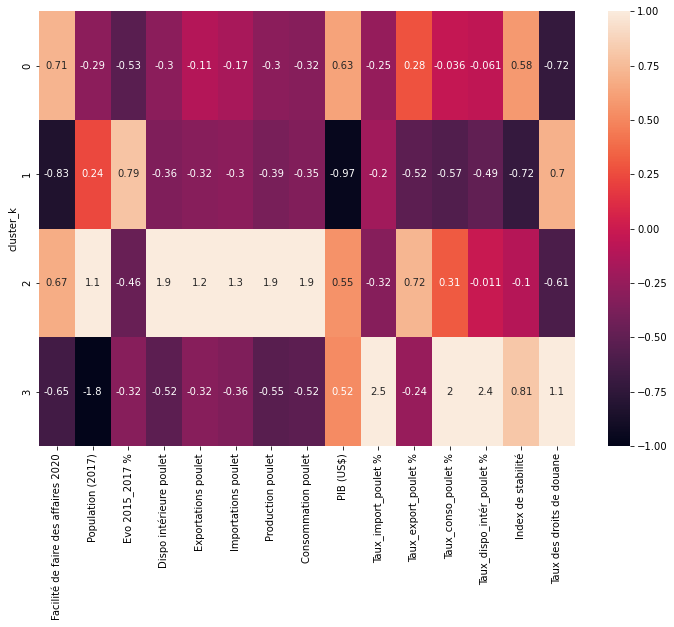

In [63]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(X_clustered_moy,annot=True, vmin=-1, vmax=1)

cluster 0 est plus intérassant pour nous exportation du poulet.

# Analyse en composantes principales (ACP)

L'acp nous aidera à: </br>

Réduire le nombre de variables étudiées par la détermination des liaisons entres celles-ci et si besoin est, de déterminer les variables synthétiques.
Comprendre les variations entre les individus.

## Calcul des composantes principales

In [64]:
# Nombre de composantes souhaitées
n_comp = 13

# Calcul des composantes principales
pca = PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=13)

In [65]:
# Proportion de variance expliquée
pca.explained_variance_ratio_

array([0.31887968, 0.23620192, 0.14874448, 0.07534791, 0.0473701 ,
       0.03856533, 0.03383835, 0.0274299 , 0.01924085, 0.01810546,
       0.01621333, 0.01050961, 0.00846159])

In [66]:
# Cumul de variance expliquée
pca.explained_variance_ratio_.cumsum()

array([0.31887968, 0.5550816 , 0.70382608, 0.77917399, 0.82654409,
       0.86510942, 0.89894777, 0.92637767, 0.94561852, 0.96372398,
       0.9799373 , 0.99044691, 0.9989085 ])

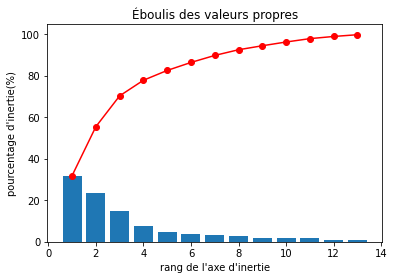

In [67]:
display_scree_plot(pca)
plt.show()

On va choisir 4 composantes principales, car les 4 premières dimensions représentent 74.96% des informations importantes.

## Cercle des corrélations

In [68]:
# Créer un modèle PCA pour réduire nos données à 4 dimensions pour la visualisation.
#pca = PCA(n_components=4)
#pca.fit(X_scaled)

#X_reduced = pca.transform(X_scaled)

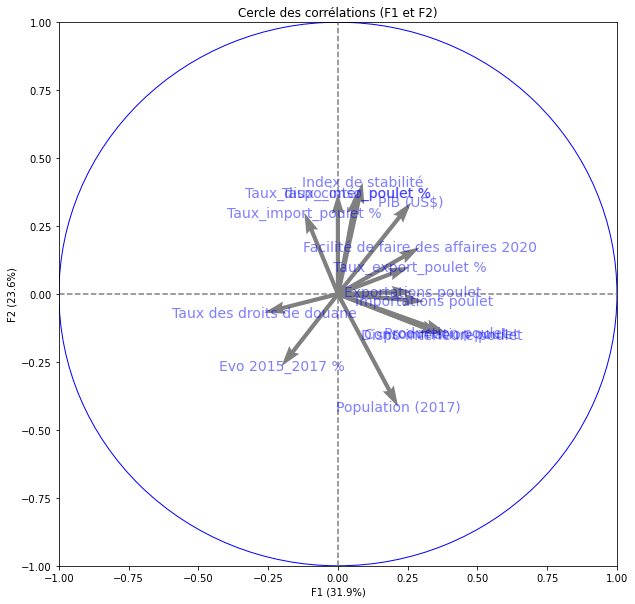

In [69]:
# Générer le Cercle des corrélations F1 et F2.
pcs = pca.components_ 
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(X.columns))

In [70]:
X.columns

Index(['Facilité de faire des affaires 2020', 'Population (2017)',
       'Evo 2015_2017 %', 'Dispo intérieure poulet', 'Exportations poulet',
       'Importations poulet', 'Production poulet', 'Consommation poulet',
       'PIB (US$)', 'Taux_import_poulet %', 'Taux_export_poulet %',
       'Taux_conso_poulet %', 'Taux_dispo_intér_poulet %',
       'Index de stabilité', 'Taux des droits de douane'],
      dtype='object')

In [71]:
F1 = pca.components_[0]
F1

array([ 2.93823027e-01,  2.15755583e-01, -2.02766427e-01,  3.72408884e-01,
        2.68211897e-01,  3.09609896e-01,  3.87714742e-01,  3.71628846e-01,
        2.62512195e-01, -1.20587211e-01,  2.56098004e-01,  6.67899034e-02,
       -3.09124384e-04,  8.84992458e-02, -2.64111923e-01])

<span style="font-size: 110%"> Avec le cercle des corrélations F1-F2 (la projection de la flèche sur F1 correspond au coefficient de corrélation ), on peut trouver des variables qui sont bien corrélées aux composantes principales: </span>


avec le cercle représenté ci-dessus, 
<li>Les variables les plus corrélées positivement à F1 sont :</li>

- Consommation poulet
- Dispo intérieure poulet
- Production poulet
- Exportations poulet
- Importations poulet

<li>Les variables corrélées légèrement positivement à F1 sont :</li>

- Facilité de faire des affaires 2020
- Population (2017)
- Taux_export_poulet %

<li>Les variables corrélées négativement à F1 sont :</li>

- Evo 2015_2017 %
- Taux des droits de douane



In [72]:
F2 = pca.components_[1]
F2

array([ 0.17162269, -0.41509654, -0.26610197, -0.14869349,  0.00883833,
       -0.02750957, -0.14226316, -0.14877512,  0.33703716,  0.29937896,
        0.09999375,  0.37109608,  0.37153418,  0.41037545, -0.06880584])

In [73]:
X.columns

Index(['Facilité de faire des affaires 2020', 'Population (2017)',
       'Evo 2015_2017 %', 'Dispo intérieure poulet', 'Exportations poulet',
       'Importations poulet', 'Production poulet', 'Consommation poulet',
       'PIB (US$)', 'Taux_import_poulet %', 'Taux_export_poulet %',
       'Taux_conso_poulet %', 'Taux_dispo_intér_poulet %',
       'Index de stabilité', 'Taux des droits de douane'],
      dtype='object')


<li>Les variables les plus corrélées positivement à F2 sont :</li>

- Population (2017)
- Evo 2015_2017 %

<li> Les variables les plus corrélées négativement à F2 sont :</li>

- Index de stabilité
- Taux_dispo_intér_poulet %
- Taux_conso_poulet %
- PIB (US$)
- Facilité de faire des affaires 2020

<li> Les variables corrélées légèrement négativement à F2 sont : </li>

- Taux_export_poulet %
- Taux_import_poulet %
- Exportations poulet

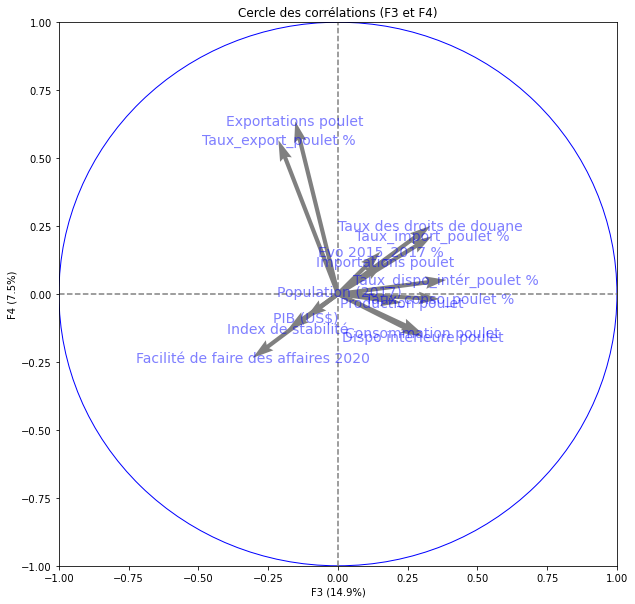

In [74]:
# Générer le Cercle des corrélations F3 et F4
pcs = pca.components_ 
display_circles(pcs, n_comp, pca, [(2,3)], labels = np.array(X.columns))

In [75]:
F3 = pca.components_[2]
F3

array([-0.30507792,  0.004543  ,  0.15221867,  0.30242059, -0.15307431,
        0.16781435,  0.22833276,  0.30206536, -0.11544895,  0.33648161,
       -0.21347177,  0.36387412,  0.3881644 , -0.1798914 ,  0.33128527])

<li>Les variables les plus corrélées positivement à F3 sont :</li>

- Taux_import_poulet %
- Taux_conso_poulet %
- Taux_dispo_intér_poulet %
- Taux des droits de douane

<li>Les variables les plus corrélées négativement à F3 sont :</li>

- Facilité de faire des affaires 2020

<li>Les variables légèrement corrélées négativement à F3 sont :</li>

- Exportations poulet
- PIB (US$) 
- Taux_export_poulet 

In [76]:
X.columns

Index(['Facilité de faire des affaires 2020', 'Population (2017)',
       'Evo 2015_2017 %', 'Dispo intérieure poulet', 'Exportations poulet',
       'Importations poulet', 'Production poulet', 'Consommation poulet',
       'PIB (US$)', 'Taux_import_poulet %', 'Taux_export_poulet %',
       'Taux_conso_poulet %', 'Taux_dispo_intér_poulet %',
       'Index de stabilité', 'Taux des droits de douane'],
      dtype='object')

In [77]:
F4 = pca.components_[3]
F4

array([-0.23487755,  0.00580664,  0.15571925, -0.15673688,  0.63545946,
        0.11733007, -0.03242794, -0.14485333, -0.08798504,  0.21260618,
        0.5662473 , -0.01840008,  0.05201389, -0.13057497,  0.25040399])

<li>Les variables les plus corrélées positivement à F4 sont :</li>

- Taux_export_poulet %
- Exportations poulet

<li>Les variables les plus corrélées négativement à F4 sont :</li>

- Facilité de faire des affaires 2020

<li>Les variables légèrement corrélées négativement à F4 sont :</li>

- Dispo intérieure poulet
- PIB (US$) 
- Index de stabilité

## Projection des individus

In [78]:
# Créer le dataframe avec les valeurs des composantes principales
X_projected = pca.transform(X_scaled)
df_ACP = pd.DataFrame(X_projected, index=X.index, columns=["F"+str(i+1) for i in range (13)]).reset_index()
df_ACP = df_ACP[['Zone','F1','F2','F3','F4']]
df_ACP.head()

,Zone,F1,F2,F3,F4
0,Afghanistan,-2.128372,-3.361204,0.263136,0.572358
1,Afrique du Sud,3.529552,-0.370853,3.117723,-0.184245
2,Albanie,-0.513929,0.727827,-1.223309,-0.852930
3,Algérie,-1.246558,-1.988638,0.141158,0.104010
4,Allemagne,5.777644,-0.376524,-0.096204,1.600616


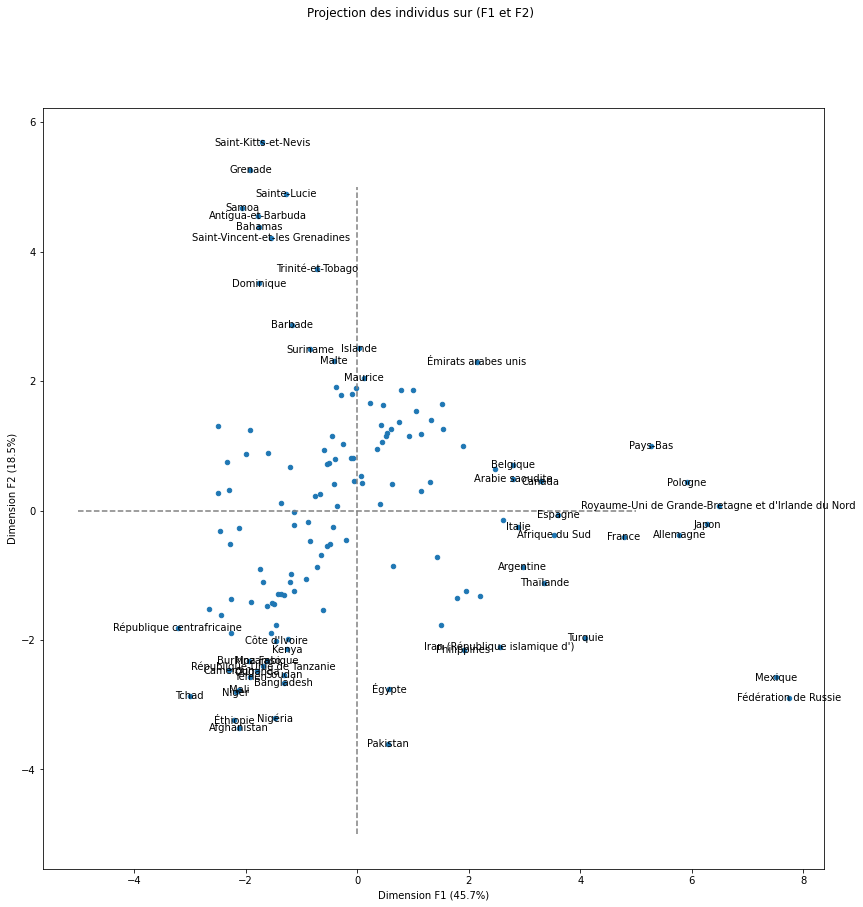

In [79]:
# utilisation de subplots nécessaire car annotation du graphique
fig, ax = plt.subplots(figsize=(14,14))
df_ACP.plot.scatter("F1", "F2", ax = ax) # l'option ax permet de placer les points et le texte sur le même graphique


# boucle sur chaque pays
for k in df_ACP.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (abs(k[1]['F1']) > 2.7) | (abs(k[1]['F2']) > 2):
        ax.annotate(k[1]["Zone"],(k[1]['F1'], k[1]['F2']), fontsize = 10, ha='center',va='center')

# affichage des lignes horizontales et verticales
plt.plot([-5, 5], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-5, 5], color='grey', ls='--')
        
plt.xlabel("Dimension F1 (45.7%)") 
plt.ylabel("Dimension F2 (18.5%)")
plt.suptitle("Projection des individus sur (F1 et F2)")
plt.show()

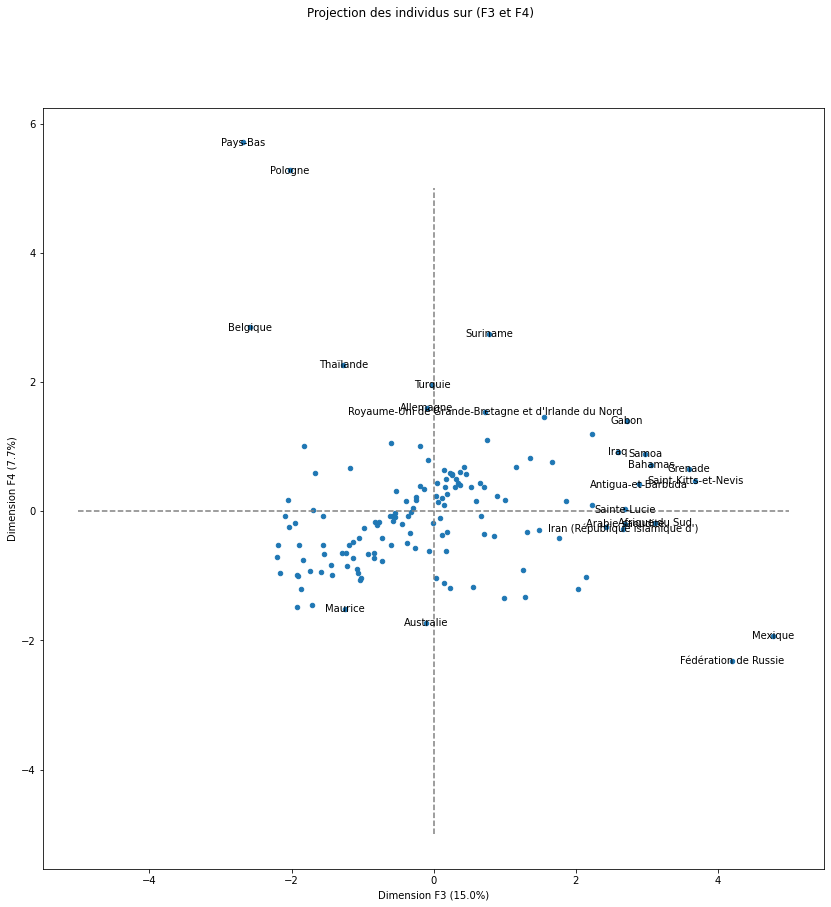

In [80]:
# utilisation de subplots nécessaire car annotation du graphique
fig, ax = plt.subplots(figsize=(14,14))
df_ACP.plot.scatter("F3", "F4", ax = ax) # l'option ax permet de placer les points et le texte sur le même graphique


# boucle sur chaque pays
for k in df_ACP.iterrows():
    # annotation uniquement si valeur absolue sur une de 2 dimensions importantes (valeurs choisies empiriquement)
    if (abs(k[1]['F3']) > 2.5) | (abs(k[1]['F4']) > 1.5):
        ax.annotate(k[1]["Zone"],(k[1]['F3'], k[1]['F4']), fontsize = 10, ha='center',va='center')

# affichage des lignes horizontales et verticales
plt.plot([-5, 5], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-5, 5], color='grey', ls='--')
        
plt.xlabel("Dimension F3 (15.0%)") 
plt.ylabel("Dimension F4 (7.7%)")
plt.suptitle("Projection des individus sur (F3 et F4)")
plt.show()

In [81]:
# Projection des individus sur F1 et F2 
#X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected, n_comp, pca, [(0, 1)],labels = np.array(X.index))

#plt.show()

In [82]:
# Projection des individus sur F3 et F4 
#X_projected = pca.transform(X_scaled)
#display_factorial_planes(X_projected, n_comp, pca, [(2, 3)],labels = np.array(X.index))

#plt.show()

# Interprétation des groupes

In [83]:
# Créer un modèle PCA pour réduire nos données à 4 dimensions pour la visualisation.
pca = PCA(n_components=4)
pca.fit(X_scaled)

X_reduced = pca.transform(X_scaled)

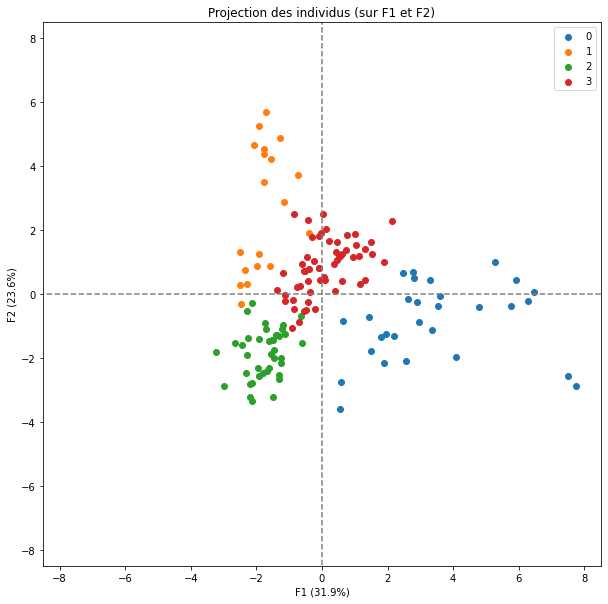

In [84]:
# Projection des individus sur F1 et F2
display_factorial_planes(X_reduced, 4, pca, [(0,1)], illustrative_var = clusters)

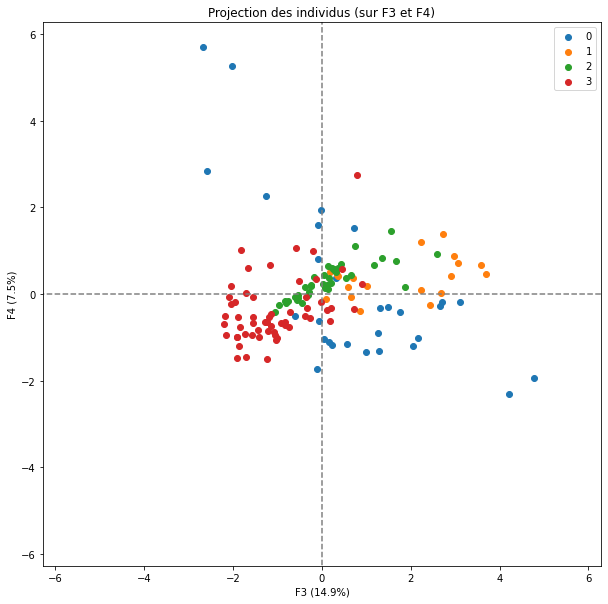

In [85]:
# Projection des individus sur F1 et F2
display_factorial_planes(X_reduced, 4, pca, [(2,3)], illustrative_var = clusters)

In [86]:
palette = sns.color_palette("bright", 10)

def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(15, 8))
    title = fig.suptitle("Coordonnées parallèles pour les centroïdes", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)
    plt.xticks(fontsize = 13, rotation = 30)
    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)

In [87]:
# Créer un dataframe contenant les centroïdes
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids['cluster'] = centroids.index

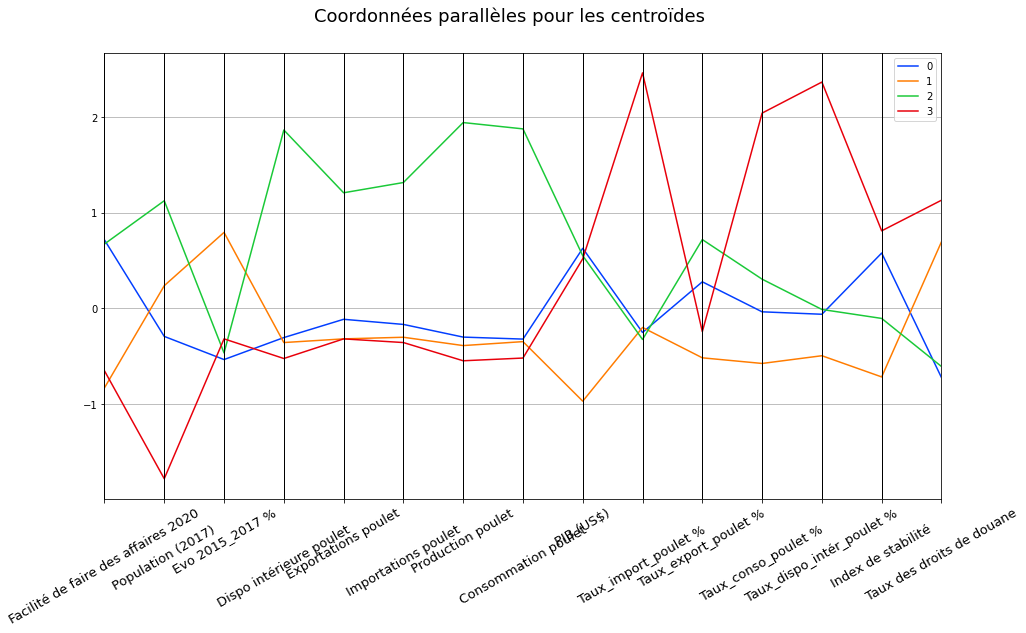

In [88]:
display_parallel_coordinates_centroids(centroids, 12)

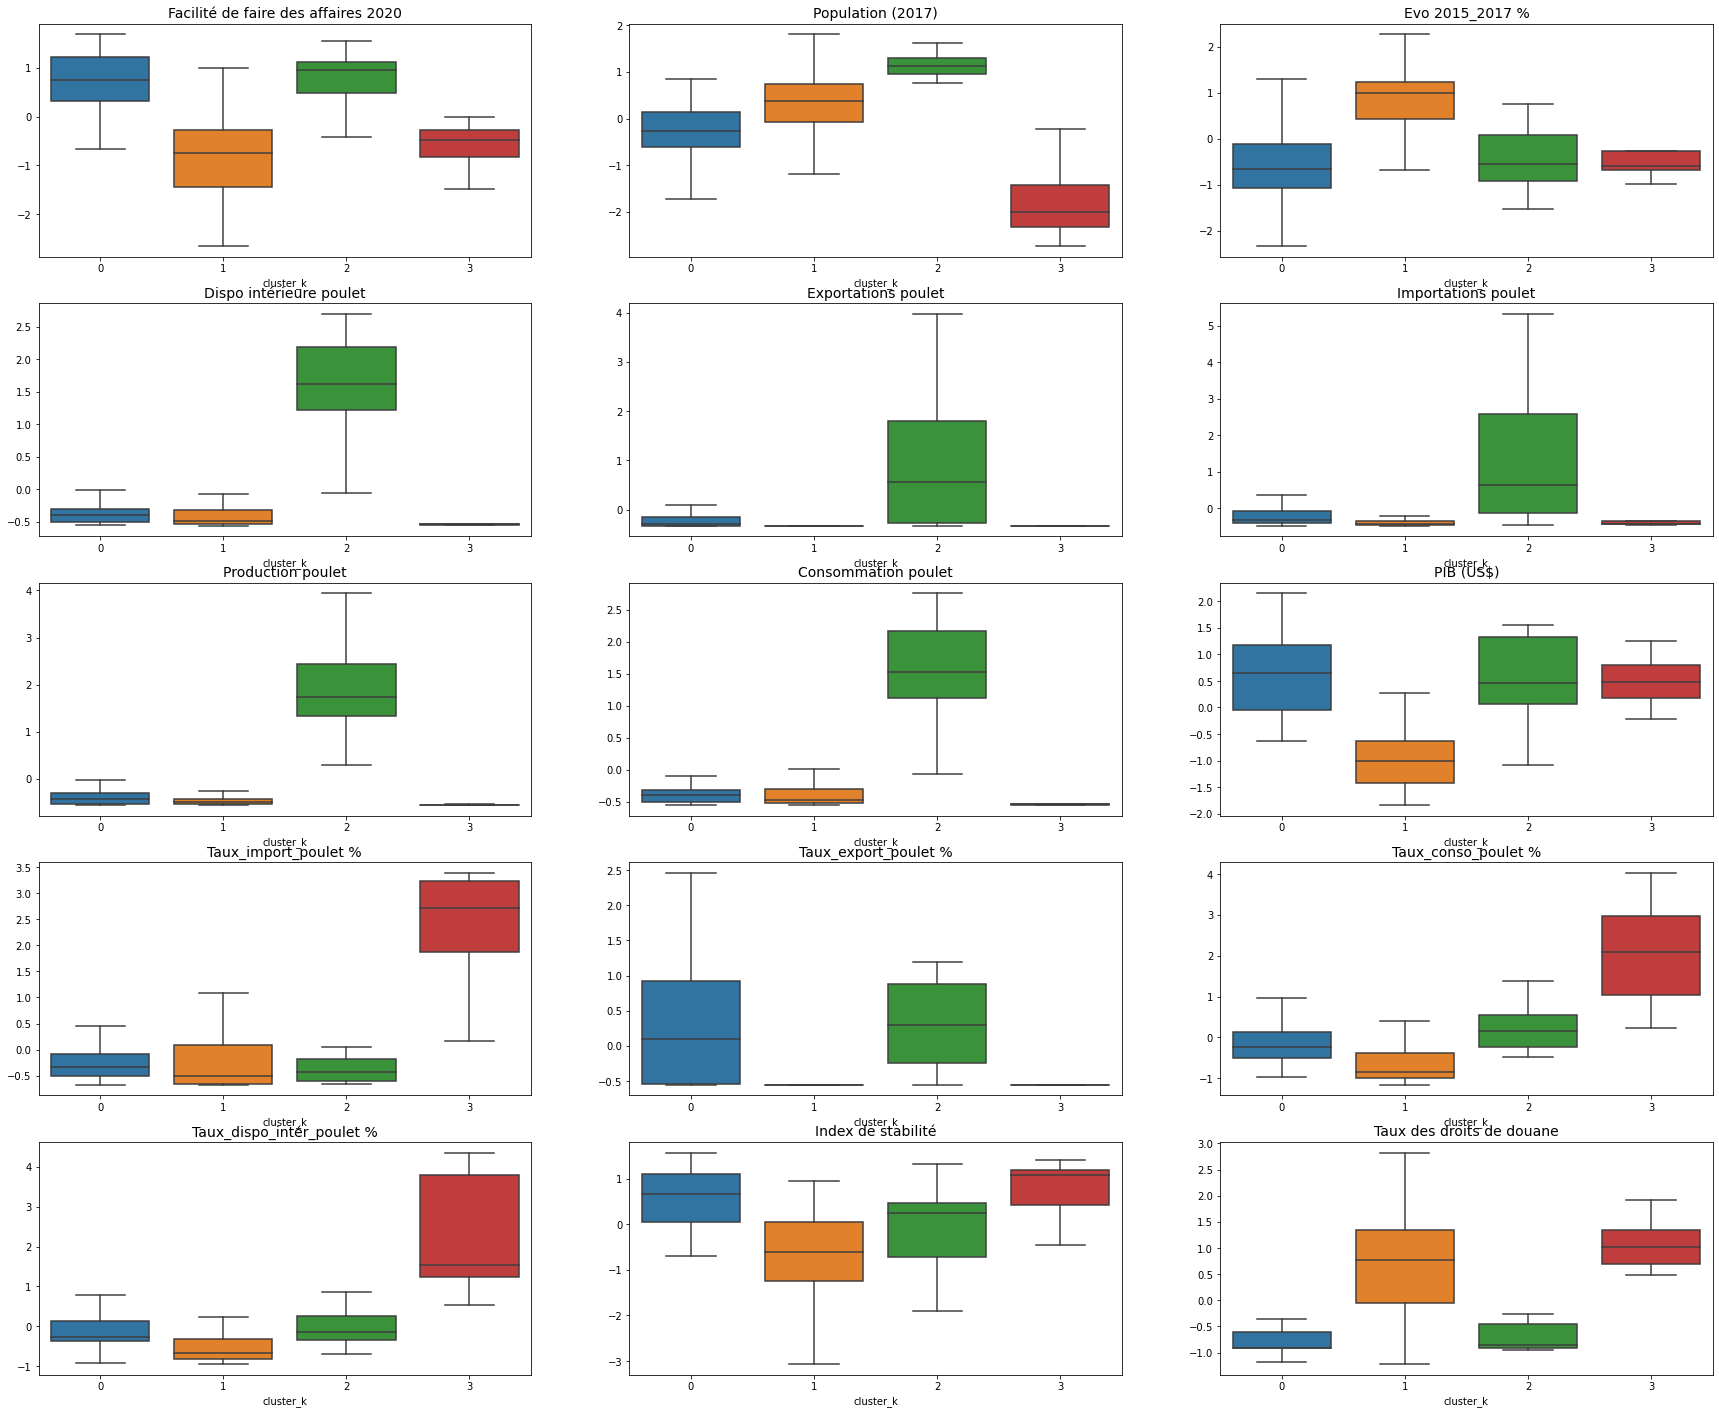

In [89]:
k = X_scaled_clustered_km[X_scaled_clustered_km.columns[:15]].values

# boxplot de chaque indicateur
fig = plt.figure(figsize=(30, 30))
for feat_idx in range(k.shape[1]):
    ax = fig.add_subplot(6, 3, (feat_idx+1))
    ax = sns.boxplot(data=X_scaled_clustered_km, y=k[:, feat_idx], x='cluster_k', showfliers=False)
    ax.set_title(X_scaled_clustered_km.columns[feat_idx], fontsize=14);

In [90]:
#m = folium.Map(location=[20, 10], zoom_start=2, tiles='cartodbpositron')

In [91]:
#f = open("countries.json", "r")

In [92]:
#f = open ('countries.json', "r")
#country_shapes = json.loads(f.read())

In [93]:
#folium.Choropleth(
#    geo_data=country_shapes,
#    data=map_cah,
#    columns=['Cluster'],
#    key_on='feature.id',
#    fill_color = "Set2",
#    fill_opacity = 0.7,
#    line_opacity = 0.2,
#    legend_name = 'Cluster CAH',
#    bins=4,
#    reset=True,
#).add_to(m)
#m

# Conclusion

Selon nos analyses, nous pouvons conclure que le groupe de pays sélectionnés pour pouvoir exporter notre poulet, est dans le groupe 0, car ils présentent une plus grande Facilité de faire des affaires qui nous permettra d'entrer dans ces pays sans problèmes, de même leur PIB représente une grande stabilité et la marché de poulet est très fréquenté. 

In [94]:
groupe0_km

,Facilité de faire des affaires 2020,Population (2017),Evo 2015_2017 %,Dispo intérieure poulet,Exportations poulet,Importations poulet,Production poulet,Consommation poulet,PIB (US$),Taux_import_poulet %,Taux_export_poulet %,Taux_conso_poulet %,Taux_dispo_intér_poulet %,Index de stabilité,Taux des droits de douane,cluster_k
Zone,,,,,,,,,,,,,,,,
Albanie,0.300864,-0.534452,-1.191596,-0.499871,-0.320278,-0.277362,-0.539903,-0.488989,-0.170891,0.463020,-0.553149,-0.660352,-0.414182,0.521282,-0.986507,0
Arménie,0.836047,-0.523077,-0.811578,-0.499871,-0.320278,-0.293675,-0.542670,-0.488989,-0.274279,0.420809,-0.553149,-0.540634,-0.350471,-0.560216,-0.550921,0
Australie,1.363360,0.637372,0.032906,1.017949,-0.093714,-0.396993,1.198246,1.089106,1.676426,-0.605467,-0.434346,0.919936,-0.101418,1.072846,-1.071024,0
Autriche,1.166602,0.076796,-0.431560,-0.329724,0.100485,0.114155,-0.353079,-0.330337,1.533299,-0.365387,0.931883,-0.396971,-0.448933,1.245886,-0.904158,0
Azerbaïdjan,1.009195,0.136941,-0.135991,-0.389141,-0.320278,-0.337177,-0.413970,-0.373861,-0.231756,-0.404961,-0.553149,-0.516690,-0.373639,-0.700811,0.060200,0
Bélarus,0.820307,0.114544,-1.064923,-0.205490,0.499670,-0.369804,0.082842,-0.184321,0.009764,-0.528958,2.461466,-0.029833,-0.443142,0.056238,-0.843479,0
Belgique,0.875399,0.218064,-0.600457,-0.358082,3.218447,1.353960,0.082842,-0.352801,1.481129,-0.441896,2.446616,-0.680305,-0.697986,0.575357,-0.904158,0
Bosnie-Herzégovine,0.119846,-0.452328,-2.078304,-0.489068,-0.277123,-0.429619,-0.473477,-0.476353,-0.041637,-0.555341,1.199189,-0.500727,-0.379430,-0.268212,-0.605098,0
Botswana,0.182809,-0.681265,0.581820,-0.553886,-0.320278,-0.467683,-0.550974,-0.545149,0.234429,-0.587000,-0.553149,-0.935706,-0.686402,1.213441,-1.051520,0
